### **Crack Detection**

Obtaining the dataset

The dataset provided is uploaded to google drive and can be accessed from at https://drive.google.com/uc?id=11DEcZ7g34rdsXsB-HdhpE6S3tL7QLZlj .

The full dataset constists 32107 images.
We start with downloading the data, a .zip of 32107 JPG pictures of cracks and no-cracks, and extracting it locally in /tmp/CrackDetection.


In [ ]:
!mkdir -p /tmp/CrackDetection
!pip install gdown
import os

os.makedirs("/tmp/CrackDetection", exist_ok=True)
!gdown "https://drive.google.com/uc?id=11DEcZ7g34rdsXsB-HdhpE6S3tL7QLZlj" -O /tmp/CrackDetection/concerete_crack_images.zip


Downloading...
From (original): https://drive.google.com/uc?id=11DEcZ7g34rdsXsB-HdhpE6S3tL7QLZlj
From (redirected): https://drive.google.com/uc?id=11DEcZ7g34rdsXsB-HdhpE6S3tL7QLZlj&confirm=t&uuid=f62973cc-1d7b-4b17-8032-7a11c4a6a8cf
To: /tmp/CrackDetection/concerete_crack_images.zip
100% 268M/268M [00:04<00:00, 57.5MB/s]


Extract the contents of the .zip to the base directory /tmp/CrackDetection, which contains training and test subdirectories for the training datasets and predict values for the test dataset, training directory contains positive(crack) and negative(no-crack) subdirectories.

In [ ]:
!ls /tmp/CrackDetection/
!file /tmp/CrackDetection/concerete_crack_images.zip

concerete_crack_images.zip
/tmp/CrackDetection/concerete_crack_images.zip: Zip archive data, at least v2.0 to extract, compression method=store


In [ ]:
import os
import zipfile

local_zip = '/tmp/CrackDetection/concerete_crack_images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/CrackDetection/')
zip_ref.close()


In [ ]:
!ls /tmp/CrackDetection/concerete_crack_images/training/
!ls /tmp/CrackDetection/


Negative  Positive
concerete_crack_images	concerete_crack_images.zip  __MACOSX


Adding a prefix "crack_" to the files with cracks inside the positive folder.

In [ ]:
import os

# Specify the folder path
folder_path = "/tmp/CrackDetection/concerete_crack_images/training/Positive"

# Specify the prefix
prefix = "crack_"

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    # Build the original and new file paths
    old_file_path = os.path.join(folder_path, filename)
    new_file_path = os.path.join(folder_path, prefix + filename)

    # Rename the file
    if os.path.isfile(old_file_path):  # Ensure it's a file, not a directory
        os.rename(old_file_path, new_file_path)

print("Files renamed successfully!")



Files renamed successfully!


The training directory contains positive and negative subdirectories. We put all the images into the same directory.

In [ ]:
!cp -a /tmp/CrackDetection/concerete_crack_images/training/Negative/. /tmp/CrackDetection/train/
!cp -a /tmp/CrackDetection/concerete_crack_images/training/Positive/. /tmp/CrackDetection/train/


Selecting 20% of random images from the training set and moving them to a validation folder for testing the models later.

In [ ]:
import os
import shutil
import random

def move_files(source_folder, target_folder, percentage=20):
    """
    Moves a specified percentage of files from source_folder to target_folder.

    Parameters:
        source_folder (str): Path to the source folder.
        target_folder (str): Path to the target folder.
        percentage (int): Percentage of files to move (default is 20).
    """
    # Ensure the target folder exists
    os.makedirs(target_folder, exist_ok=True)

    # Get the list of files in the source folder
    files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]

    # Calculate the number of files to move
    num_files_to_move = int(len(files) * (percentage / 100))
    print(num_files_to_move)
    # Randomly select files to move
    files_to_move = random.sample(files, num_files_to_move)

    # Move the selected files
    for file_name in files_to_move:
        source_path = os.path.join(source_folder, file_name)
        target_path = os.path.join(target_folder, file_name)
        shutil.move(source_path, target_path)
        # print(f"Moved: {source_path} -> {target_path}")

    # print(f"Moved {num_files_to_move} files from {source_folder} to {target_folder}")
move_files("/tmp/CrackDetection/train", "/tmp/CrackDetection/validation")

6421


In [ ]:
train_data_dir = "/tmp/CrackDetection/train"
test_data_dir = "/tmp/CrackDetection/validation"

train_imgs = os.listdir(train_data_dir)
test_imgs = os.listdir(test_data_dir)
print(len(train_imgs))
print(len(test_imgs))

25686
6421


In [ ]:
import numpy as np
import pandas as pd
import os
#from scipy import ndimage #This package contains various functions for multi-dimensional image processing.
import cv2
import scipy
import matplotlib.pyplot as plt
import sys


def extrFeaturesAndLabels(dir, impg_dataset, num_px = 64):
  X = np.zeros((len(impg_dataset), num_px*num_px*3))
  y = np.zeros((len(impg_dataset)))
  for i in range(0,len(impg_dataset)) :
    #Read an image from a file as an array.
    #The different colour bands/channels are stored
    #in the third dimension, such that a
    #grey-image is MxN, an RGB-image MxNx3
    #image = np.array(ndimage.imread(dir + impg_dataset[i]))
    image = cv2.imread(os.path.join(dir, impg_dataset[i]))


    # Resize the image. Size of the output image (height, width)
    try:
      image = cv2.resize(image, (num_px, num_px))
    except:
      print("Skipping the file:" + impg_dataset[i])
      continue

    # Convert the matrix to a vector
    image = image.reshape((1, num_px*num_px*3)).T

    # Note that RGB (Red, Green, Blue) are 8 bit each.
    # Hence, the range for each individual colour is 0-255 (as 2^8 = 256 possibilities).
    # By dividing by 255, Convert the 0-255 range to a 0.0-1.0 range where 0.0 means 0 (0x00) and 1.0 means 255 (0xFF).
    image = image/255.0

    image = image.reshape((num_px*num_px*3,1))
    for j in range(0,num_px*num_px*3):
        X[i][j] = image[j][0]

    if 'crack' in impg_dataset[i]:
        y[i] = 1
    else :
        y[i] = 0

  y = y.astype(int)

  return(X, y)

def get_accuracy(model, X, y):
  y_pred = model.predict(X)

  if sys.version_info < (3, 0):
      accuracy = ((np.sum(y == y_pred, axis=0)).astype('float') /
            X.shape[0])
  else:
      accuracy = np.sum(y == y_pred, axis=0) / X.shape[0]

  # print('Accuracy: %.2f%%' % (accuracy * 100))

  return(accuracy * 100)

Training Data Set

Images can be represented as a matrix with number of elements equal to the number of pixels. However, color images are digitally represented as a volume (i.e., three-channels; or three matrices stacked on each other). The number three is used because colors are represented as red-green-blue (RGB) values. Here, we have a chosen pixel_size × chosen pixel_size × 3 image for each example.

## **Single model training**

In [ ]:
from scipy import ndimage
train_X, train_Y = extrFeaturesAndLabels(train_data_dir, train_imgs)

In [ ]:
print(test_imgs)

['crack_860.jpg', '13992.jpg', '6945.jpg', 'crack_10266.jpg', '2611.jpg', '1390.jpg', '5670.jpg', '7379.jpg', '15992.jpg', '5041.jpg', '4443.jpg', '130.jpg', 'crack_5486.jpg', 'crack_6814.jpg', '5008.jpg', '15087.jpg', 'crack_1338.jpg', 'crack_5843.jpg', '7920.jpg', 'crack_14679.jpg', 'crack_4962.jpg', 'crack_12603.jpg', '8807.jpg', '6403.jpg', 'crack_4438.jpg', '7863.jpg', 'crack_968.jpg', '12965.jpg', 'crack_8580.jpg', '6442.jpg', 'crack_13701.jpg', 'crack_12986.jpg', '49.jpg', 'crack_6065.jpg', 'crack_2282.jpg', '8285.jpg', '10625.jpg', '11576.jpg', '9589.jpg', 'crack_9408.jpg', 'crack_10867.jpg', '4810.jpg', '10980.jpg', '8161.jpg', '4553.jpg', 'crack_12252.jpg', '4921.jpg', 'crack_15780.jpg', 'crack_4653.jpg', '9390.jpg', 'crack_9118.jpg', 'crack_1417.jpg', '11637.jpg', '14344.jpg', 'crack_9167.jpg', 'crack_2065.jpg', 'crack_6172.jpg', 'crack_12926.jpg', '3012.jpg', 'crack_11157.jpg', 'crack_2784.jpg', '2743.jpg', 'crack_8591.jpg', 'crack_2112.jpg', 'crack_12239.jpg', 'crack_2747.

In [ ]:
test_X, test_Y = extrFeaturesAndLabels(test_data_dir, test_imgs)

In [ ]:
print('Training Data set - Rows: %d, columns: %d' % (train_X.shape[0], train_X.shape[1]))
print('Test Data set - Rows: %d, columns: %d' % (test_X.shape[0], test_X.shape[1]))

Training Data set - Rows: 25686, columns: 12288
Test Data set - Rows: 6421, columns: 12288


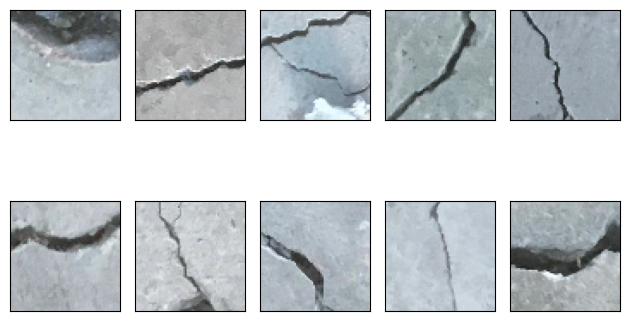

In [ ]:
#10 different images of cracks:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
num_px = 64
for i in range(10):
    img = train_X[train_Y == 1][i].reshape(num_px, num_px, 3)
    ax[i].imshow(img)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

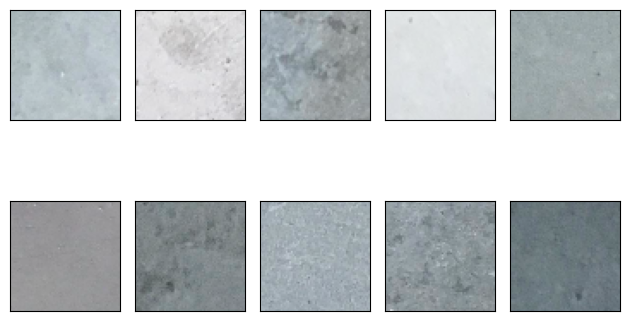

In [ ]:
#10 different images of No Cracks:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = train_X[train_Y == 0][i].reshape(num_px, num_px, 3)
    ax[i].imshow(img)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
print('Training data shape : ', train_X.shape, train_Y.shape) #print the shape of the training data using the train_X.shape, train_Y.shape functions.

print('Testing data shape : ', test_X.shape, test_Y.shape) #print the shape of the test data using the test_X.shape and test_Y.shape functions.

Training data shape :  (25686, 12288) (25686,)
Testing data shape :  (6421, 12288) (6421,)


In [ ]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


In [ ]:
train_X = train_X.reshape(-1, 64,64, 3) # convert each 64 x 64 x 3  image of the train datta into a matrix of size 64 x 64 x 3  which is fed into the network.
test_X = test_X.reshape(-1, 64,64, 3) #  # convert each 64 x 64 x 3  image of the train datta into a matrix of size 64 x 64 x 3  which is fed into the network.

print('Training data shape : ', train_X.shape, train_Y.shape) #print the shape of the training data using the train_X.shape, train_Y.shape functions.
print('Testing data shape : ', test_X.shape, test_Y.shape) #print the shape of the test data using the test_X.shape and test_Y.shape functions.


Training data shape :  (25686, 64, 64, 3) (25686,)
Testing data shape :  (6421, 64, 64, 3) (6421,)


In [ ]:
# Change the labels from categorical to one-hot encoding
import keras
train_Y_one_hot = keras.utils.to_categorical(train_Y, 2)
test_Y_one_hot = keras.utils.to_categorical(test_Y, 2)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 1
After conversion to one-hot: [0. 1.]


In [ ]:
import keras
from keras.models import Sequential#,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


In [ ]:
model = Sequential()#create a convolutional neural network (CNN) model for image classification.
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(64,64,3),padding='same')) #apply 32 filters of size 3*3.  The padding parameter is set to 'same', which means that the output size of the layer will be the same as the input size.
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.5, input_shape=(2,)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax')) #num_classes = 2



In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,142,210 (4.36 MB)

 Trainable params: 1,142,210 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Compile the specified model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [ ]:
#Fit the model using the training data
batch_size = 25
epochs = 10
model.fit(train_X, train_Y_one_hot, batch_size=batch_size, epochs=epochs,verbose=1) # The verbose argument is set to 1, which means that the evaluation progress and results will be displayed on the console.

Epoch 1/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 260s 251ms/step - accuracy: 0.9137 - loss: 0.1829
Epoch 2/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 267s 259ms/step - accuracy: 0.9880 - loss: 0.0385
Epoch 3/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 263s 256ms/step - accuracy: 0.9905 - loss: 0.0307
Epoch 4/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 255s 248ms/step - accuracy: 0.9957 - loss: 0.0158
Epoch 5/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 262s 255ms/step - accuracy: 0.9944 - loss: 0.0178
Epoch 6/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 259s 252ms/step - accuracy: 0.9927 - loss: 0.0219
Epoch 7/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 242s 233ms/step - accuracy: 0.9964 - loss: 0.0121
Epoch 8/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 261s 232ms/step - accuracy: 0.9964 - loss: 0.0117
Epoch 9/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 238s 231ms/step - accuracy: 0.9975 - loss: 0.0083
Epoch 10/10
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 290s 258ms/step - accuracy: 0.9962 - loss: 0.0097


In [ ]:
#Fit the model using the training data
batch_size = 10
epochs = 20
model.fit(train_X, train_Y_one_hot, batch_size=batch_size, epochs=epochs,verbose=1) # The verbose argument is set to 1, which means that the evaluation progress and results will be displayed on the console.

Epoch 1/20
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 266s 103ms/step - accuracy: 0.9940 - loss: 0.0240
Epoch 2/20
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 316s 101ms/step - accuracy: 0.9970 - loss: 0.0111
Epoch 3/20
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 259s 100ms/step - accuracy: 0.9968 - loss: 0.0128
Epoch 4/20
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 266s 102ms/step - accuracy: 0.9970 - loss: 0.0119
Epoch 5/20
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 262s 102ms/step - accuracy: 0.9975 - loss: 0.0117
Epoch 6/20
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 257s 100ms/step - accuracy: 0.9975 - loss: 0.0104
Epoch 7/20
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 262s 100ms/step - accuracy: 0.9972 - loss: 0.0092
Epoch 8/20
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 260s 99ms/step - accuracy: 0.9981 - loss: 0.0093
Epoch 9/20
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 275s 104ms/step - accuracy: 0.9975 - loss: 0.0108
Epoch 10/20
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 258s 101ms/step - accuracy: 0.9992 - loss: 0.0036
Epoch 11/20
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 262s 101ms/step - accuracy: 0.9986 - 

In [ ]:
model.evaluate(test_X, test_Y_one_hot, verbose=1)

201/201 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.9971 - loss: 0.0146


[0.015511222183704376, 0.9967294931411743]

In [ ]:
predict_data = os.listdir("/tmp/CrackDetection/concerete_crack_images/test")
predict_data_x, predict_data_y = extrFeaturesAndLabels("/tmp/CrackDetection/concerete_crack_images/test", predict_data)

In [ ]:
predict_data_x = predict_data_x.reshape(-1, 64,64, 3)
predicted_classes = model.predict(predict_data_x)

247/247 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step


In [ ]:
classified_data = np.argmax(np.round(predicted_classes),axis=1)

In [ ]:
import csv
import numpy as np

output_data = zip(predict_data, predicted_classes, classified_data)

# Write to a CSV file
csv_file_path = "predictions.csv"  # Specify your desired output file path
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write header
    writer.writerow(["Image Name", "Predicted Class", "Classification"])
    # Write data
    writer.writerows(output_data)


## **Multi model training for observation - 30 combinations**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense


# Model with 2 Convolutional Layers
def get_model(num_px, num_layers, extra_dense_layer=False):
  model = Sequential()
  if num_layers == 2:
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(num_px, num_px, 3), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
  elif num_layers == 3:
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(num_px, num_px, 3), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
  elif num_layers == 4:
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(num_px, num_px, 3), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
  elif num_layers == 6:
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(num_px, num_px, 3), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    if extra_dense_layer:
      model.add(Dense(512, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model


In [ ]:
from scipy import ndimage
import keras
from keras.models import Sequential#,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from itertools import product
import time

model_summary = {}
best_cnn_model = None
best_model_detail = None
model_id = 1

# image resolution 32 and 64
for num_px in [32, 64]:

  model_name = "model_" + str(model_id)

  train_X, train_Y = extrFeaturesAndLabels(train_data_dir, train_imgs, num_px)
  test_X, test_Y = extrFeaturesAndLabels(test_data_dir, test_imgs)

  print(model_name + ': Training Data set - Rows: %d, columns: %d' % (train_X.shape[0], train_X.shape[1]))
  print(model_name + ': Test Data set - Rows: %d, columns: %d' % (test_X.shape[0], test_X.shape[1]))

  train_X = train_X.reshape(-1, num_px, num_px, 3) # convert each 64 x 64 x 3  image of the train datta into a matrix of size 64 x 64 x 3  which is fed into the network.
  test_X = test_X.reshape(-1,  num_px, num_px, 3) #  # convert each 64 x 64 x 3  image of the train datta into a matrix of size 64 x 64 x 3  which is fed into the network.

  print(model_name + ': Training data shape : ', train_X.shape, train_Y.shape) #print the shape of the training data using the train_X.shape, train_Y.shape functions.
  print(model_name + ': Testing data shape : ', test_X.shape, test_Y.shape) #print the shape of the test data using the test_X.shape and test_Y.shape functions.

  train_Y_one_hot = keras.utils.to_categorical(train_Y, 2)
  test_Y_one_hot = keras.utils.to_categorical(test_Y, 2)

  # comvolutional layers of 3 and 6
  for convolutional_layers in [3, 6]:
    model = get_model(num_px, convolutional_layers)

    batch = [1, 25, 100]
    epoch = [10, 20]

    # Generate all combinations of batch and epoch
    combinations = list(product(batch, epoch))
    for batch_size, epochs in combinations:
      model_name = "model_" + str(model_id)
      print("-----------------------------------")
      print("processing model : "+model_name)
      start_time = time.time()
      model.fit(train_X, train_Y_one_hot, batch_size=batch_size, epochs=epochs, verbose=1)
      end_time = time.time()
      print(f"Training Time: {end_time - start_time} seconds")
      # accuracy = get_accuracy(model, test_X, test_Y)
      test_loss, test_accuracy = model.evaluate(test_X, test_Y_one_hot, verbose=1)
      model_summary[model_name] = {"conv_layers" : convolutional_layers,
                                   "resolution_image" : num_px,
                                   "batch_size" : batch_size,
                                   "epochs" : epochs,
                                   "test_loss" : test_loss,
                                   "test_accuracy" : test_accuracy,
                                   "start_time" : start_time,
                                   "end_time" : end_time,
                                   "training_time" : end_time - start_time,
                                   "dense_layers": (128) }
      if best_cnn_model is None or test_accuracy > best_model_detail["test_accuracy"]:
        best_cnn_model = model
        best_model_detail = model_summary[model_name]
      model_id += 1



In [ ]:
num_px = 64
convolutional_layers = 6
batch = [1, 25, 100]
epoch = [10, 20]
model = get_model(num_px, convolutional_layers, True)
combinations = list(product(batch, epoch))
for batch_size, epochs in combinations:
  model_name = "model_" + str(model_id)
  print("-----------------------------------")
  print("processing model : "+model_name)
  start_time = time.time()
  model.fit(train_X, train_Y_one_hot, batch_size=batch_size, epochs=epochs, verbose=1)
  end_time = time.time()
  print(f"Training Time: {end_time - start_time} seconds")
  # accuracy = get_accuracy(model, test_X, test_Y)
  test_loss, test_accuracy = model.evaluate(test_X, test_Y_one_hot, verbose=1)
  model_summary[model_name] = {"conv_layers" : convolutional_layers,
                                "resolution_image" : num_px,
                                "batch_size" : batch_size,
                                "epochs" : epochs,
                                "test_loss" : test_loss,
                                "test_accuracy" : test_accuracy,
                                "start_time" : start_time,
                                "end_time" : end_time,
                                "training_time" : end_time - start_time,
                                "dense_layers": (512, 128) }
  if best_cnn_model is None or test_accuracy > best_model_detail["test_accuracy"]:
    best_cnn_model = model
    best_model_detail = model_summary[model_name]
  model_id += 1

In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(model_summary, orient="index")

# Display the DataFrame as a table
print(df.to_markdown())

|          |   conv_layers |   resolution_image |   batch_size |   epochs |   test_loss |   test_accuracy |   start_time |    end_time |   training_time | dense_layers   |
|:---------|--------------:|-------------------:|-------------:|---------:|------------:|----------------:|-------------:|------------:|----------------:|:---------------|
| model_1  |             3 |                 32 |            1 |       10 |  0.0208422  |        0.995328 |  1.73396e+09 | 1.73396e+09 |        654.932  | 128            |
| model_2  |             3 |                 32 |            1 |       20 |  0.017327   |        0.995951 |  1.73396e+09 | 1.73396e+09 |       1326.63   | 128            |
| model_3  |             3 |                 32 |           25 |       10 |  0.0149169  |        0.995328 |  1.73396e+09 | 1.73396e+09 |         34.3788 | 128            |
| model_4  |             3 |                 32 |           25 |       20 |  0.0307512  |        0.997508 |  1.73396e+09 | 1.73396e+09 |    

In [ ]:
predict_data = os.listdir("/tmp/CrackDetection/concerete_crack_images/test")
predict_data_x, predict_data_y = extrFeaturesAndLabels("/tmp/CrackDetection/concerete_crack_images/test", predict_data)
predict_data_x = predict_data_x.reshape(-1, best_model_detail["resolution_image"], best_model_detail["resolution_image"], 3)
predicted_classes = best_cnn_model.predict(predict_data_x)
classified_data = np.argmax(np.round(predicted_classes),axis=1)

Skipping the file:.DS_Store
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
import csv
import numpy as np

predicted_data = [value[:-4] for value in predict_data]
output_data = zip(predict_data, predicted_classes, classified_data)

# Write to a CSV file
csv_file_path = "predictions.csv"  # Specify your desired output file path
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write header
    writer.writerow(["Image Name", "Predicted probability","Predicted Class"])
    # Write data
    writer.writerows(output_data)



##**SUMMARY**

**Model data summary**

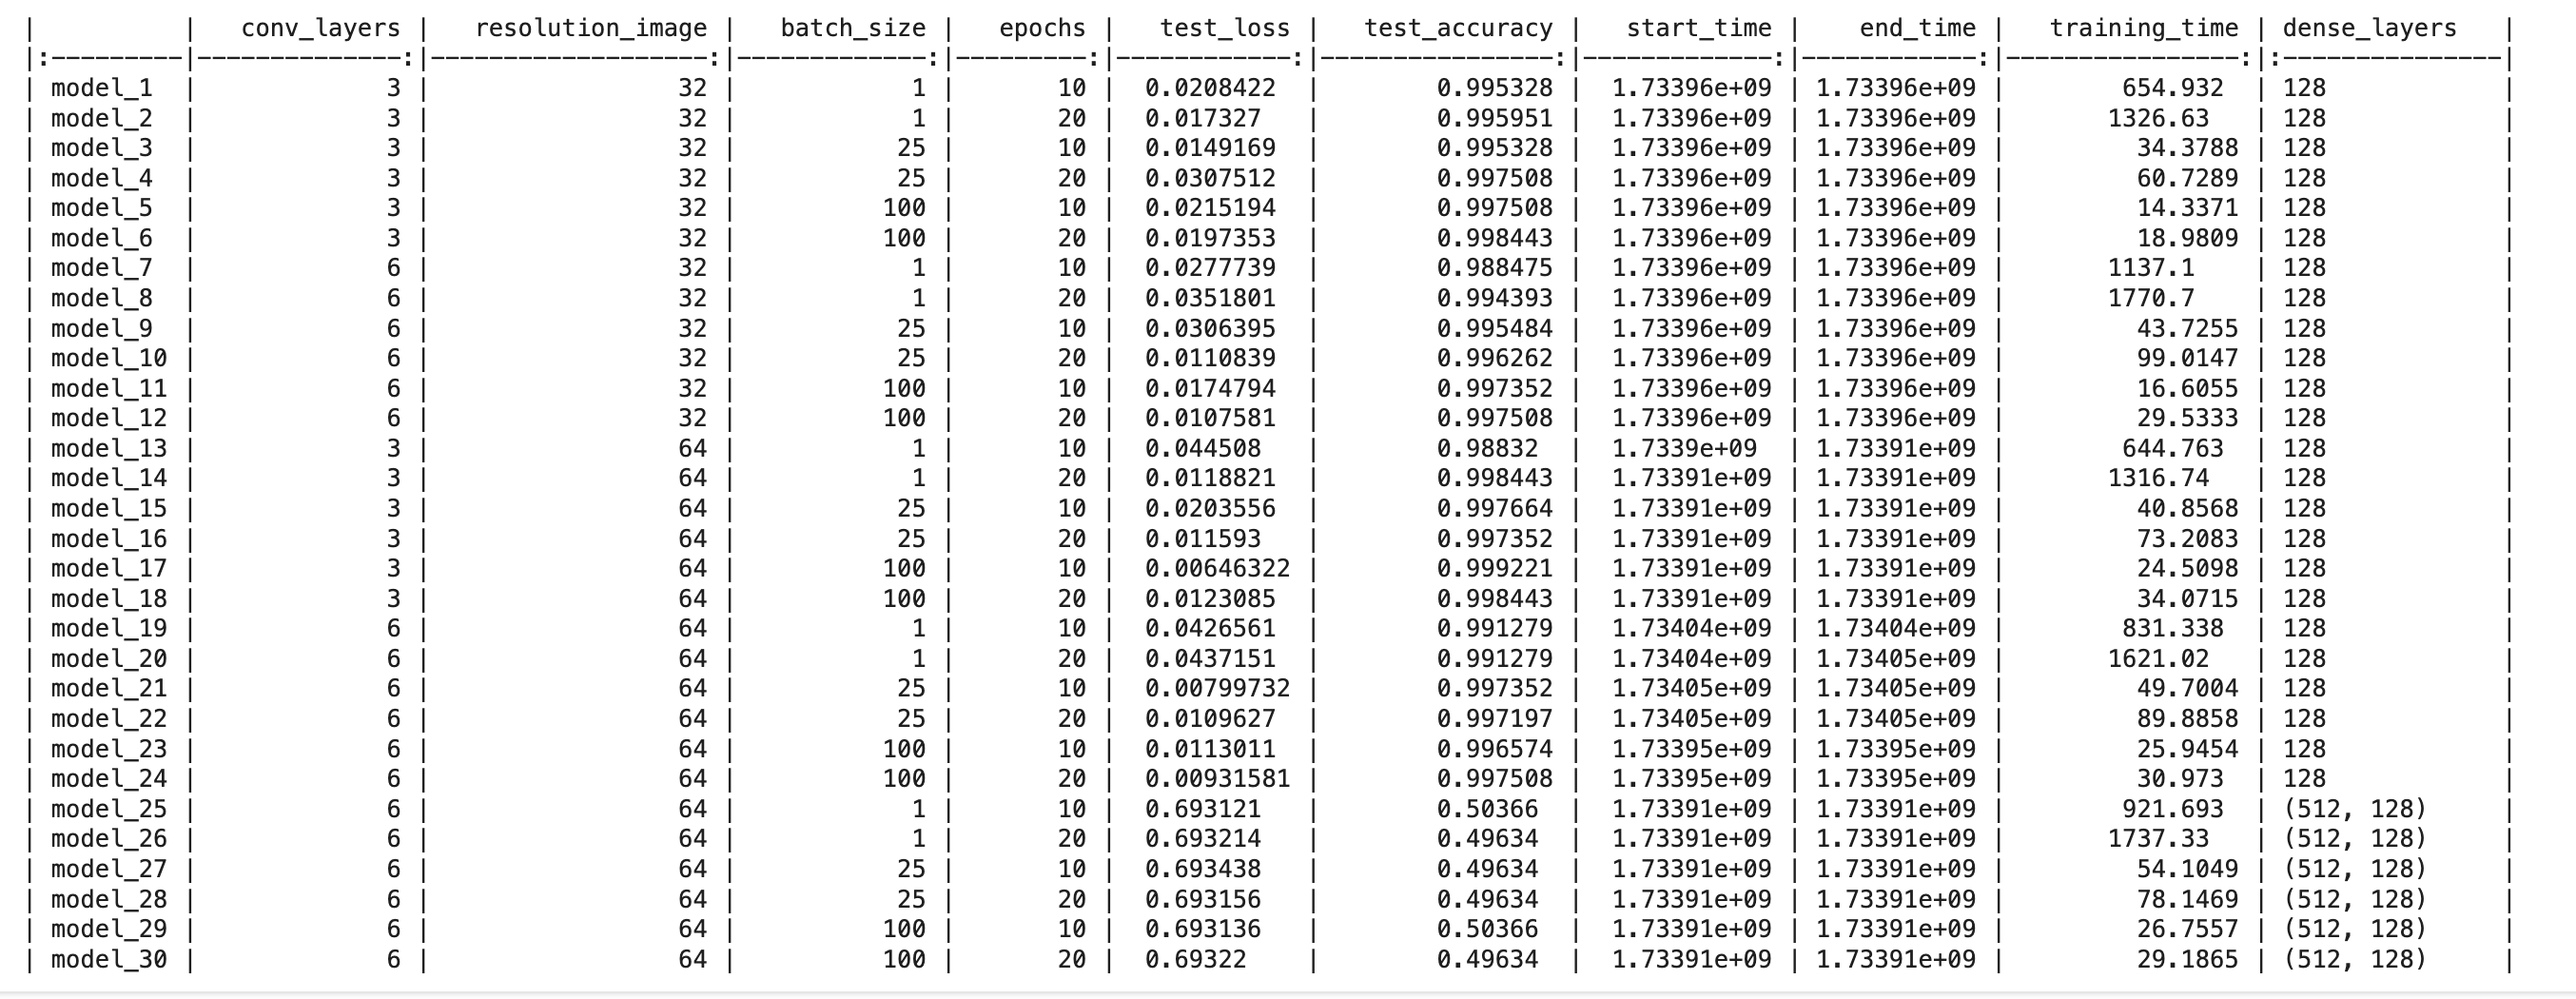

**1. Impact of Image Resolution**

32x32 Resolution: Models trained on lower resolution images performed well in terms of computational time but showed slightly reduced accuracy compared to higher resolutions.

64x64 Resolution: Higher resolution improved accuracy in most cases but at the cost of increased training time. Models with 64x64 resolution consistently achieved higher test accuracies, demonstrating the benefit of higher resolution for detailed feature detection.

**2. Change in Number of Convolutional Layers**

3 Convolutional Layers: Provided a good balance of accuracy and training time. Models with 3 layers generally performed well, achieving accuracies above 99% in many configurations.

6 Convolutional Layers: Improved feature extraction in complex datasets, leading to higher accuracy in some cases. However, these models often required significantly more computational time, particularly with smaller batch sizes.

**3. Batch Size for Training**

Batch Size 1: Resulted in the highest computational time due to frequent weight updates but did not significantly improve accuracy compared to larger batch sizes.

Batch Size 25: Struck a balance between training time and accuracy. Models with this batch size often performed comparably to those with batch size 1 but trained faster.

Batch Size 100: Offered the fastest training times while maintaining high accuracy. These models were ideal for efficient training without substantial accuracy trade-offs.

**4. Model Performance**

Test accuracy ranged from 50% to 99.9%, depending on the configuration.

Models with smaller dense layers (‘128’) consistently outperformed those with larger dense layers (‘512, 128’) in terms of accuracy and training time. Larger dense layers added complexity without a corresponding improvement in performance.

**5. Computational Time**

Training time varied significantly across configurations:

Batch size 1 with 6 convolutional layers required up to 1621 seconds for 20 epochs.

Batch size 100 with 3 convolutional layers trained in as little as 14 seconds for 10 epochs.

Increasing the number of epochs significantly increased training time but only marginally improved accuracy beyond a certain point.

**6. Accuracy on Test Dataset**

Models with batch size 100 and 6 convolutional layers at 64x64 resolution achieved the highest accuracy (up to 99.9%).

Models with smaller dense layers consistently achieved better accuracy compared to those with larger dense layers.

**7. Network Size**

Adding a second dense layer (‘512, 128’) negatively impacted performance, leading to lower accuracy and longer training times.

Models with a single dense layer (‘128’) demonstrated a better balance between performance and computational efficiency.



#**Conclusions**

**Image Resolution Matters**: Higher resolution images (64x64) are crucial for achieving high accuracy, particularly for detailed tasks like crack detection.

**Balance Between Depth and Efficiency**: Increasing convolutional layers improves feature extraction but comes with a computational cost. For many cases, 3 layers are sufficient.

**Batch Size Optimization**: Larger batch sizes (e.g., 100) optimize training time without sacrificing accuracy, making them suitable for large datasets.

**Network Size**: Simpler networks with a single dense layer outperform more complex configurations for this dataset.

**Epoch Limitations**: Increasing epochs improves accuracy only up to a point, after which returns diminish. Proper epoch selection is essential to balance training time and performance.

#**Future Improvements**

1. Remove duplicate images from the dataset to ensure cleaner and more diverse training data.

2. Implement cross-validation to better assess model performance and generalization capabilities.